# Analysis of the Ethereum Blockchain Arbitrages and Liquidations

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection

The data consists of a list of arbitrage transactions, liquidations, block features which are stored on a postgres db.
Additionally, general features of the blockchain e.g. number of protocol usages in the transactions are stored in the db directory.
The arbitrage transactions were collected using calls to multiple Erigon RPC endpoints.

The first collection of data is from block 15200000 to 15500000 or from Jul-23-2022 04:32:35 PM +UTC to Sep-09-2022 01:39:42 AM +UTC.
These blocks are pre-merge blocks. The next collection will analyse the post-merge blocks.

First, we must connect to our database.

In [183]:
# Connect to db
from sqlalchemy import create_engine, text
from db import get_inspect_database_uri

conn = create_engine(get_inspect_database_uri()).connect()

# Arbitrage Analysis

## Data Loading and Cleaning

In [184]:
query = "SELECT * FROM arbitrages WHERE block_number BETWEEN 15200000 AND 15500000"
arb_df = pd.DataFrame(conn.execute(text(query)))
arb_df.set_index('id', inplace=True)
arb_df['timestamp'] = pd.to_datetime(arb_df['timestamp'])
arb_df = arb_df.sort_values('block_number')

In [185]:
arb_df.head()

,transaction_hash,block_number,timestamp,account_address,status,contracts_address,input_tokens_address,input_tokens_amount,output_tokens_address,output_tokens_amount,protocols,gas_price,gas_usage,block_position,profit_amount
id,,,,,,,,,,,,,,,
34,0xd39500706630fb26ea405ce04d7b5884df0866cb1a1c...,15200022,2022-07-23 21:08:45,0xd8c7031da609a6e201e038dd11c97d7f26f1d572,True,"{0xfca9090d2c91e11cc546b0d7e4918c79e0088194,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{5120123648171978000,10837504868.0,7798609065.0}","{0x70e8de73ce538da2beed35d14187f6959a8eca96,0x...","{10837504868.0,7798609065.0,5133779858359948000}",{uniswap_v3},163839,68917,0,1.365621e+16
35,0x63c9c17d97c181b8819783b599a59940a786b5bd2bb6...,15200028,2022-07-23 21:09:18,0xd7c09e006a2891880331b0f6224071c1e890a98a,True,"{0x2c51eaa1bcc7b013c3f1d5985cdcb3c56dc3fbc1,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{240470594654432770,22176822844245777000000}","{0x2d94aa3e47d9d5024503ca8491fce9a2fb4da198,0x...","{22176822844245777000000,248404143686549860}",{uniswap_v2},229745,136481,63,7.933549e+15
37,0xc9c502aec6b07d452ed4ce1e35c20e6cea0cda91e21a...,15200029,2022-07-23 21:09:57,0x5aa3393e361c2eb342408559309b3e873cd876d6,True,"{0xb404057ee4b1d7359ca5a57ac1c020b74c23e56b,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{1906092123352685000,105673083691328340000}","{0x50d1c9771902476076ecfc8b2a83ad6b9355a4c9,0x...","{105673083691328340000,1939547111027948800}","{uniswap_v3,uniswap_v2}",947727,65768,33,3.345499e+16
36,0x2eb09482b29b2d32a240142dee1e7ec6288719c7f049...,15200029,2022-07-23 21:09:57,0xe8c060f8052e07423f71d445277c61ac5138a2e5,True,"{0x06db071bebeb0570a8f3aa0e49238140bedc268f,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{203776686158774270,2011097854535.0,1272233986...","{0x53fd2342b43ecd24aef1535bc3797f509616ce8c,0x...","{2011097854535.0,12722339869926854000000,22747...",{uniswap_v2},474200,37474,37,2.369401e+16
38,0x7acd0000e5e346c66e58aac81c4f48ad6022c6a0184c...,15200034,2022-07-23 21:11:19,0xd8c7031da609a6e201e038dd11c97d7f26f1d572,True,"{0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{6483562585462506000,9898566457.0,120839032289...","{0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x...","{9898566457.0,120839032289753.0,64965197108999...",{uniswap_v3},156765,60038,1,1.295713e+16


In [186]:
arb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114160 entries, 34 to 106593
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   transaction_hash       114160 non-null  object        
 1   block_number           114160 non-null  int64         
 2   timestamp              114160 non-null  datetime64[ns]
 3   account_address        114160 non-null  object        
 4   status                 114160 non-null  bool          
 5   contracts_address      114160 non-null  object        
 6   input_tokens_address   114160 non-null  object        
 7   input_tokens_amount    114160 non-null  object        
 8   output_tokens_address  114160 non-null  object        
 9   output_tokens_amount   114160 non-null  object        
 10  protocols              114160 non-null  object        
 11  gas_price              114160 non-null  int64         
 12  gas_usage              114160 non-null  int

## Status Analysis

Get the success rate of each address and protocol.

In [187]:
def count_features_grouped_by(df: pd.DataFrame, condition: str, _by: [str], features: [str]) -> pd.DataFrame:
    return df.loc[eval(condition)].groupby(by=_by).count().reset_index()[features]

### By Address

Get the success rate of each address

In [188]:
address_success_rate = arb_df.groupby('account_address')['status'].mean()
print('Success rate of each address:')
address_success_rate.head()

Success rate of each address:


account_address
0x0000000000000eb4ec62758aae93400b3e5f7f18    1.000000
0x000000000000660def84e69995117c0176ba446e    0.846154
0x0000000000007f150bd6f54c40a34d7c3d5e9f56    1.000000
0x0000000000036414940324055c43e75f56b7d016    1.000000
0x00000000000970375ff38f05eb9d6db32ae40708    0.666667
Name: status, dtype: float64

### By Protocol
Get the success rate of each address


In [189]:
# Split the protocols column into separate columns for each protocol
protocols_df = arb_df["protocols"].str.replace("[{}]", "", regex=True).str.get_dummies(sep=",")

# Concatenate the status column and the protocol columns
merged_df = pd.concat([arb_df["status"], protocols_df], axis=1)

# Calculate the success rate for each protocol
rates_df = merged_df.mean()
rates_df = rates_df.drop("status")

rates_df

balancer_v1    0.099974
bancor         0.000044
curve          0.006289
uniswap_v2     0.852260
uniswap_v3     0.439813
dtype: float64

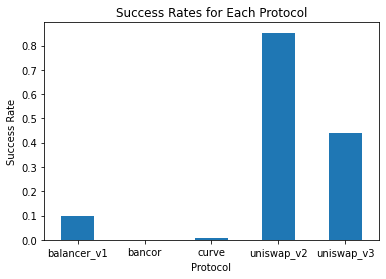

In [190]:
rates_df.plot(kind="bar", rot=0)
plt.title("Success Rates for Each Protocol")
plt.xlabel("Protocol")
plt.ylabel("Success Rate")
plt.show()

## Gas Usage Analysis

### Distribution

### Average gas usage per block
Compare average gas price for arbitrage transactions in each block with the total average gas price of that block.

First, load the blocks data.

In [191]:
# TODO: Log-transformation for heavy-tailed features
query = "SELECT * FROM blocks WHERE block_number BETWEEN 15200000 AND 15500000"
block_df = pd.DataFrame(conn.execute(text(query)))
block_df.head()

,block_number,avg_gas_price,avg_gas_usage
0,15350000,2.721346e+10,147368.451923
1,15350001,2.254700e+10,132315.841629
2,15350002,2.462672e+10,143398.263889
3,15350003,1.947772e+10,193935.637097
4,15350004,2.215424e+10,159431.977011


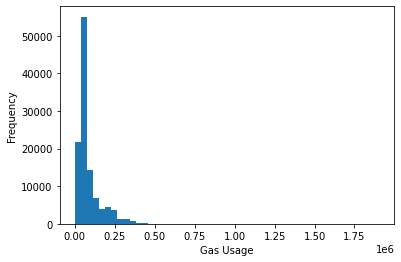

In [192]:
# Gas usage distribution

plt.hist(arb_df['gas_usage'], bins=50)
plt.xlabel('Gas Usage')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

In [193]:
avg_gas_per_block = arb_df.groupby('block_number')['gas_usage'].mean()

In [194]:
# merge the average gas usage per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

,block_number,avg_gas_price,avg_gas_usage,gas_usage
21,15200022,4.153248e+10,134339.764151,68917.0
22,15200028,2.738264e+10,200588.850000,136481.0
23,15200029,3.027934e+10,159324.673966,51621.0
24,15200034,4.212785e+10,155170.612903,60038.0
25,15200042,3.362009e+10,124875.841837,65111.0
...,...,...,...,...
65184,15499977,1.275421e+10,150213.633094,41032.0
65185,15499983,2.279058e+10,173226.878453,124695.0
65186,15499984,2.380291e+10,138621.292237,86905.0
65187,15499989,2.014510e+10,156501.361204,146233.0


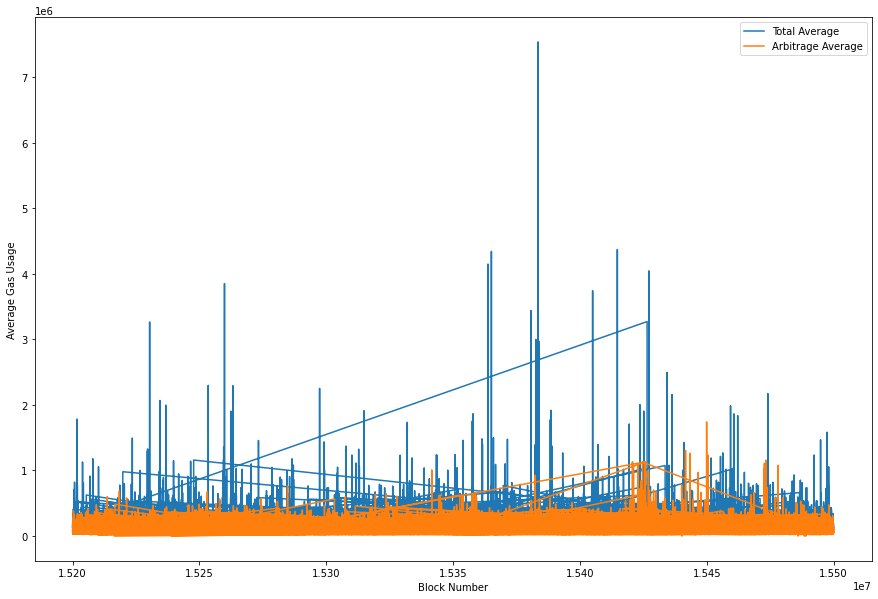

In [195]:
# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(15, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_usage'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_usage'], label='Arbitrage Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Usage')
plt.legend()
plt.show()

## Gas Price Analysis

### Distribution

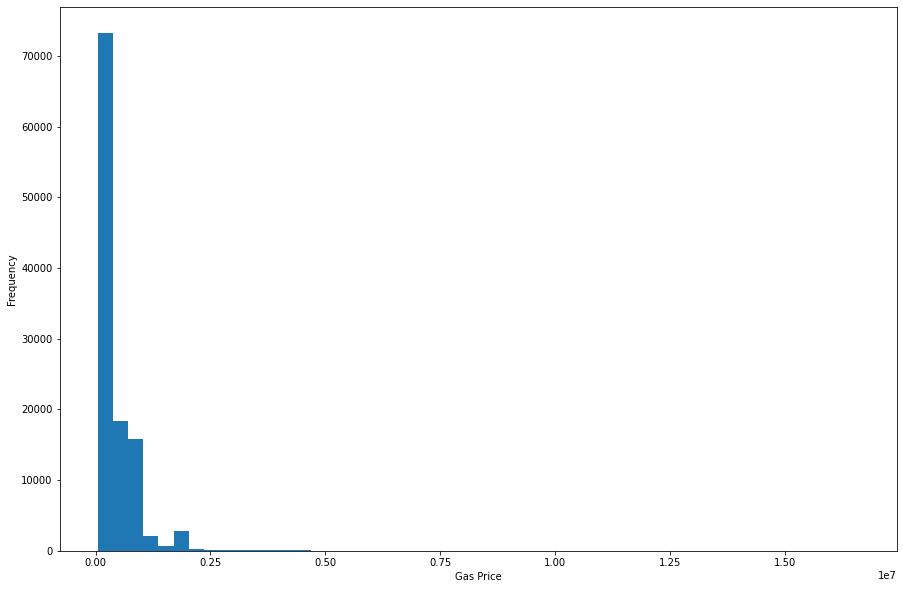

In [196]:
# Gas usage distribution

plt.figure(figsize=(15, 10))
plt.hist(arb_df['gas_price'], bins=50)
plt.xlabel('Gas Price')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

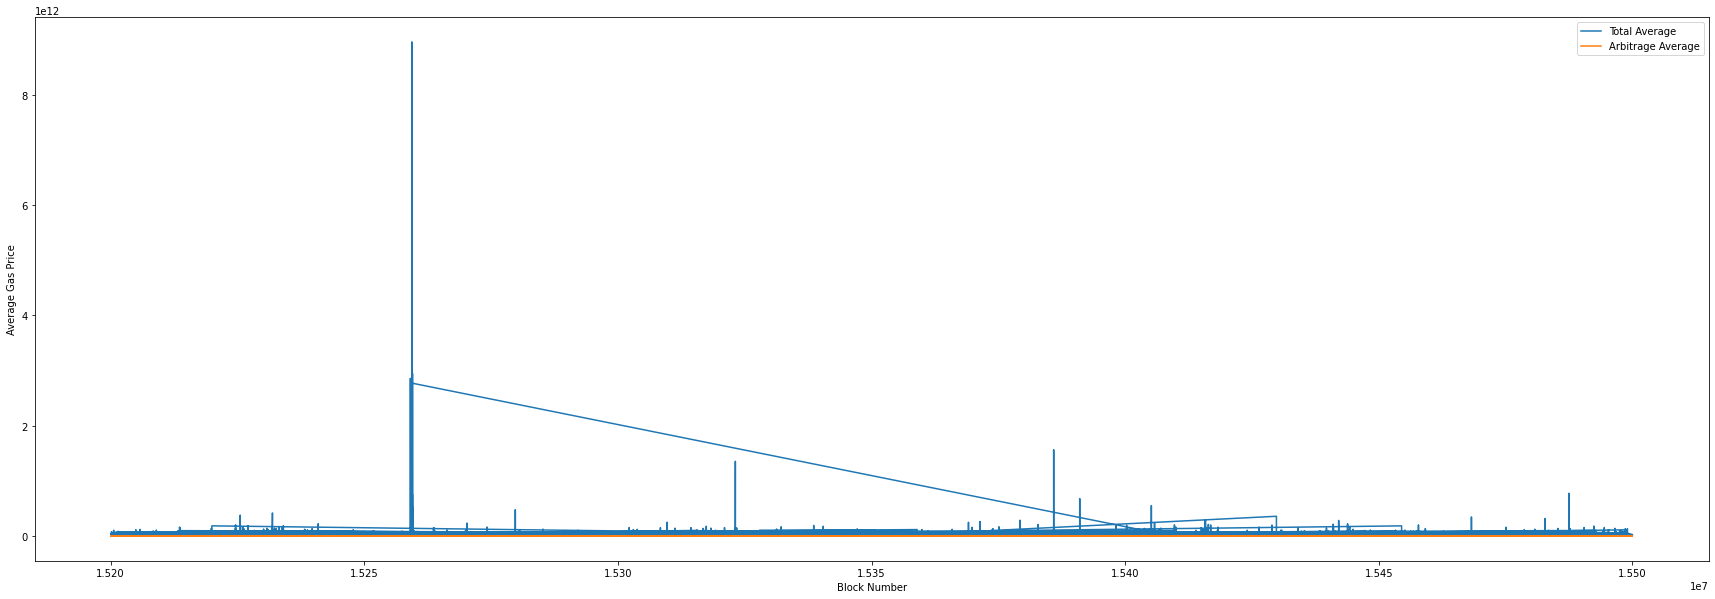

In [197]:
avg_gas_per_block = arb_df.groupby('block_number')['gas_price'].mean()

# merge the average gas price per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(30, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_price'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_price'], label='Arbitrage Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Price')
plt.legend()
plt.show()

# Analysis of the Tokens

In the first part, we show the most used tokens for profit in arbitrage.
Note that in an arbitrage transaction there might be several tokens involved but in the end the arbitrageur gains profit from a single token (this is the most basic analysis of arbitrage transactions, it's possible that the user gains profit from multiple tokens which occur in more complex arbitrages).

In [198]:
from collections import Counter


def _address_use(token_column: str):
    all_sets = pd.concat([arb_df[token_column]])
    all_strings = [string for set_ in all_sets for string in set_.split(',')]
    counts = Counter(all_strings)

    return pd.DataFrame(counts.values(), index=counts.keys(), columns=['count'])

In [199]:
# Replace the { and } characters in the relevant columns with an empty string using the str.replace method.

list_columns = ['contracts_address', 'input_tokens_address', 'input_tokens_amount', 'output_tokens_address',
                'output_tokens_amount', 'protocols']

for column in list_columns:
    arb_df[column] = arb_df[column].str.replace('[{}]', '', regex=True)

In [200]:
input_tokens = _address_use('input_tokens_address')
output_tokens = _address_use('output_tokens_address')

### Difference between input and output degrees of arbitrage transactions

In [201]:
any(input_tokens - output_tokens != 0)

True

The input and output degrees of the tokens are equal.

### Transaction Degree Analysis
Now, let's check the degree of arbitrage transactions i.e. the number of different tokens used in each transaction.

In [202]:
def get_transactions_degree():
    input_tokens_degree = pd.DataFrame(columns=['transaction_hash', 'degree'])
    output_tokens_degree = pd.DataFrame(columns=['transaction_hash', 'degree'])

    # Get degrees for output tokens
    output_tokens_degree['transaction_hash'] = arb_df['transaction_hash']
    output_tokens_degree['degree'] = arb_df['output_tokens_address'].str.count(',') + 1

    # Get degrees for input tokens
    input_tokens_degree['transaction_hash'] = arb_df['transaction_hash']
    input_tokens_degree['degree'] = arb_df['input_tokens_address'].str.count(',') + 1

    return input_tokens_degree, output_tokens_degree

In [203]:
tokens_degree, _ = get_transactions_degree()
tokens_degree

,transaction_hash,degree
id,,
34,0xd39500706630fb26ea405ce04d7b5884df0866cb1a1c...,3
35,0x63c9c17d97c181b8819783b599a59940a786b5bd2bb6...,2
37,0xc9c502aec6b07d452ed4ce1e35c20e6cea0cda91e21a...,2
36,0x2eb09482b29b2d32a240142dee1e7ec6288719c7f049...,3
38,0x7acd0000e5e346c66e58aac81c4f48ad6022c6a0184c...,3
...,...,...
106584,0x7de85a62d4ddcc9f6a25abb8700bb8ccd8f59dc3d36d...,2
106590,0xef788340c281084d5b89a923882761b3701710ce120c...,2
106591,0x4b3787dd2aa08c046462ade973471051e2a58dfbde36...,3


array([[<AxesSubplot:title={'center':'degree'}>]], dtype=object)

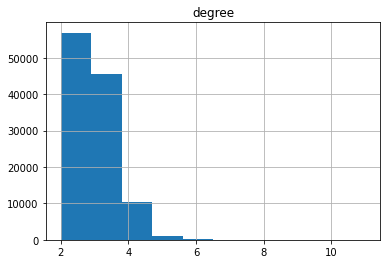

In [204]:
tokens_degree.hist('degree')

In [205]:
from tokens.name_tags import get_name_tag


def _get_name_tags(addresses):
    _public_name_tags = {}

    for address in addresses:
        _public_name_tags[address] = get_name_tag(_address=address)

    return _public_name_tags

In [206]:
# Get the 20 most used tokens
# Todo: profits?

most_used_tokens = input_tokens.nlargest(20, input_tokens.columns[0])

token_name_tags = _get_name_tags(most_used_tokens.index)

INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Tether: USDT Stablecoin
INFO:root:Already found: ShibaSwap: BONE Token
INFO:root:Already found: Shiba Inu: SHIB Token
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Already found: Shiba Inu: LEASH Token
INFO:root:Already found: Frax Finance: FRAX Token
INFO:root:Already found: FunFair Token
INFO:root:Already found: HEX.com: HEX Token
INFO:root:Already found: Unification: xFUND Token
INFO:root:Already found: Vow: VOW Token
INFO:root:Already found: Terra: LUNC Token
INFO:root:Already found: Synapse: SYN Token
INFO:root:Already found: StraitsX: XSGD Token
INFO:root:Already found: Angle Protocol: agEUR
INFO:root:Already found: Hedron: HDRN Token
INFO:root:Already found: Uniswap Protocol: UNI token
INFO:root:Already found: Animoca: REVV Token


In [207]:
def bar(ax, x, y, _rotation=75, _width=0.4):
    ax.bar(x, y, width=_width)
    ax.set_xticks( x)
    ax.set_xticklabels(x, rotation=_rotation)

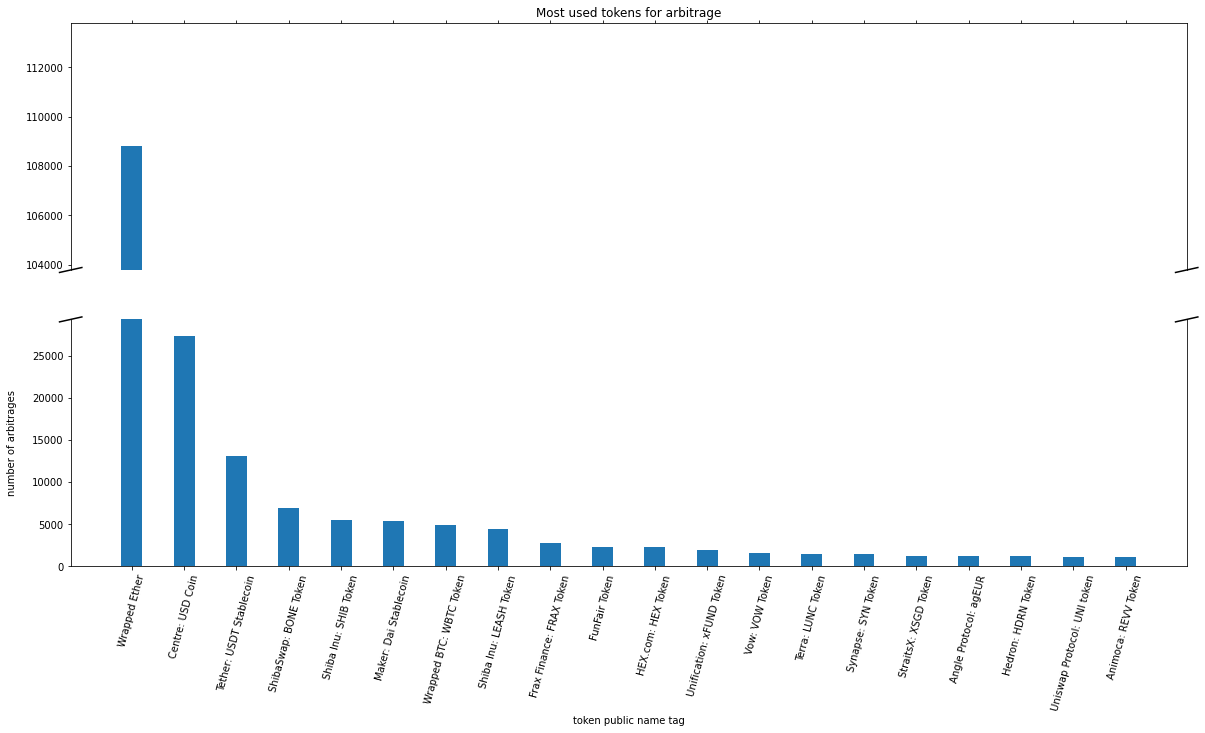

In [208]:
from matplotlib.transforms import ScaledTranslation

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

bar(ax1, most_used_tokens.index.map(token_name_tags), most_used_tokens.values.squeeze())
bar(ax2, most_used_tokens.index.map(token_name_tags), most_used_tokens.values.squeeze())

ax1.set_ylim(most_used_tokens.values[0] - 5000, most_used_tokens.values[0] + 5000)  # outliers only
ax2.set_ylim(0, most_used_tokens.values[1] + 2000)  # most of the data

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

################# Diagonal Lines #################

d = .010  # how big to make the diagonal lines in axes coordinates
kwargs = {'transform':ax1.transAxes, 'color':'k', 'clip_on':False}
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

###################################################

ax1.set_title("Most used tokens for arbitrage")

ax2.set_xlabel("token public name tag")
ax2.set_ylabel('number of arbitrages', labelpad=15)

plt.show()

The most used token is WETH. This is because arbitrageurs usually buy an arbitrage asset using ETH and gain the profit by selling them in ETH.
This might be because the WETH-TOKEN pools are more common in the exchanges.
The two latter places belong to stable coins: USDC and USDT
The three Shiba INu tokens: BONE, SHIB, and LEASH are also on top of the list.
Note that originally we only stored and counted the profit token which is usually WETH. But as mentioned before, the arbitrage opportunity is not a result of instability in WETH, rather in the instability of a certain token which is then exploited using the WETH pool.


## Active Addresses Analysis

### Most Active Addresses

In this part we take a look at the most active arbitrageurs i.e. the addresses that have the largest number of arbitrage transactions.
We can use this data along with the most profitable addresses to see if there is any relation between number of transactions and profit.

The distribution of the number of transactions by address

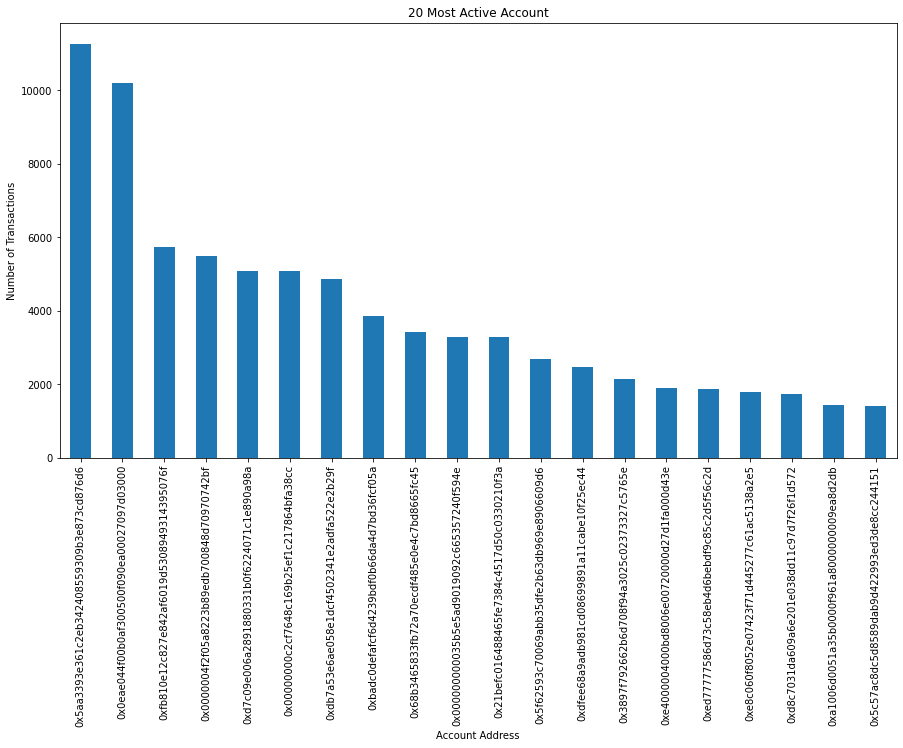

In [209]:
# Count the number of transactions for each account address
transactions_by_address = arb_df['account_address'].value_counts()

# Plot the results as a bar chart
plt.figure(figsize=(15, 8))
transactions_by_address.head(20).plot(kind='bar')
plt.title('20 Most Active Account')
plt.xlabel('Account Address')
plt.ylabel('Number of Transactions')
plt.show()

### Distribution

The distribution of the number of transactions per address.

Note: Addresses with less than 5 transactions were removed. There were around 300 accounts.

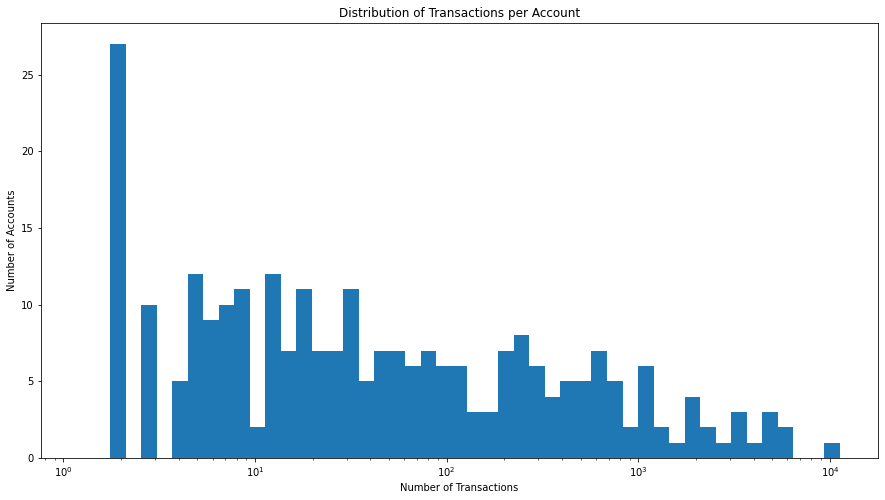

In [210]:
# Group by account address and count the number of transactions
transactions_per_account = arb_df.groupby(['account_address']).size()

# Define custom bin edges
bin_edges = np.logspace(np.log10(1), np.log10(transactions_per_account.max()), 51)

# Remove the first bin edge
bin_edges = bin_edges[1:]

# Plot the distribution of transactions per account as a histogram
plt.figure(figsize=(15, 8))
plt.hist(transactions_per_account, bins=bin_edges)
plt.xscale('log')
plt.title('Distribution of Transactions per Account')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Accounts')
plt.show()

## Ratio of arbitrage transactions

What's the ratio of arbitrage transactions to all transactions for the top 20 addresses?

In [211]:
top_addresses = transactions_by_address.head(20)
top_addresses

0x5aa3393e361c2eb342408559309b3e873cd876d6    11271
0x0eae044f00b0af300500f090ea00027097d03000    10202
0xfb810e12c827e842af6019d5308949314395076f     5727
0x0000004f2f05a8223b89edb700848d70970742bf     5500
0xd7c09e006a2891880331b0f6224071c1e890a98a     5085
0x00000000c2cf7648c169b25ef1c217864bfa38cc     5081
0xdb7a53e6ae058e1dcf4502341e2adfa522e2b29f     4867
0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a     3869
0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45     3436
0x000000000035b5e5ad9019092c665357240f594e     3282
0x21befc016488465fe7384c4517d50c0330210f3a     3275
0x5f62593c70069abb35dfe2b63db969e8906609d6     2683
0xdfee68a9adb981cd08699891a11cabe10f25ec44     2473
0x3897f792662b6d708f94a3025c02373327c5765e     2147
0xe4000004000bd8006e00720000d27d1fa000d43e     1900
0xed77777586d73c58eb4d6bebdf9c85c2d5f56c2d     1884
0xe8c060f8052e07423f71d445277c61ac5138a2e5     1787
0xd8c7031da609a6e201e038dd11c97d7f26f1d572     1745
0xa1006d0051a35b0000f961a8000000009ea8d2db     1449
0x5c57ac8dc5

### Load Accounts data

Get the total number of transactions for the top addresses

In [212]:
from pathlib import Path

adr_db_path = Path("./db/addresses/")
csv_files = adr_db_path.glob("*.csv")

all_adr_transactions = pd.concat([pd.read_csv(file, header=None, index_col=False, names=["account", "count"]) for file in csv_files])

all_adr_transactions = all_adr_transactions[all_adr_transactions['account'].isin(top_addresses.index)]
all_adr_transactions

,account,count


ValueError: x and y must have same first dimension, but have shapes (20,) and (0, 22)

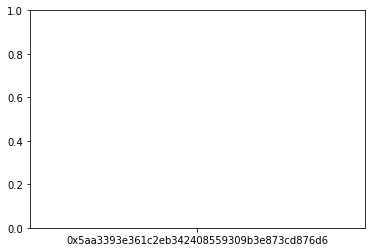

In [232]:
y_values = top_addresses / all_adr_transactions

plt.plot(top_addresses.index, y_values, 'o')
plt.xlabel('Top Addresses')
plt.ylabel('Ratio of Arbitrage Transactions')
plt.show()

## Contracts

In [233]:
contracts_df = _address_use('contracts_address')
contracts_df

,count
0xfca9090d2c91e11cc546b0d7e4918c79e0088194,1194
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,15296
0x6279653c28f138c8b31b8a0f6f8cd2c58e8c1705,1167
0x2c51eaa1bcc7b013c3f1d5985cdcb3c56dc3fbc1,33
0x59c1349bc6f28a427e78ddb6130ec669c2f39b48,30
...,...
0x726d253304a2a66463ef7be10f4ef2c8641c1bf4,1
0x18fae6a689d487a80e384b190ae3c9f9bb9f10c0,1
0xd3cec4163016b8384b304cff6c2b4c19624d7f23,1
0xef2dfdb6d8b744d795ea075f037d257e034c2f74,1


In [234]:
print(f"There are {len(contracts_df.index)} unique contracts involved in the transactions.")

There are 6730 unique contracts involved in the transactions.


In [235]:
top_n_contracts = 20
most_used_contracts = contracts_df.sort_values(by='count', ascending=False).head(top_n_contracts)
print(f"Top {top_n_contracts} contracts with the highest number of transactions:")
most_used_contracts

Top 20 contracts with the highest number of transactions:


,count
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,15296
0xefb47fcfcad4f96c83d4ca676842fb03ef20a477,5684
0x11b815efb8f581194ae79006d24e0d814b7697f6,4485
0x4585fe77225b41b697c938b018e2ac67ac5a20c0,3661
0xcf6daab95c476106eca715d48de4b13287ffdeaa,2888
0x57654ae132413e81459ad2ae70c2570a9b89fb53,2790
0x60594a405d53811d3bc4766596efd80fd545a270,2497
0xf6badfb9b0ab2f8f3fd8225ef1ea12fa689ad1a7,2475
0xff64cb7ba5717a10dabc4be3a41acd2c2f95ee22,2419
0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,2287


In [236]:
contract_name_tags = _get_name_tags(most_used_contracts.index)

INFO:root:Already found: Uniswap V3: USDC 3
INFO:root:Already found: UniswapV2Pair
INFO:root:Already found: Uniswap V3: USDT 3
INFO:root:Already found: Uniswap V3: WBTC 2
INFO:root:Already found: UniswapV2Pair
INFO:root:Already found: UniswapV2Pair
INFO:root:Already found: Uniswap V3: DAI 2
INFO:root:Already found: UniswapV2Pair
INFO:root:Already found: UniswapV2Pair
INFO:root:Already found: Uniswap V3: WBTC
INFO:root:Already found: Uniswap V3: FUN 2
INFO:root:Already found: Uniswap V3: USDC 2
INFO:root:Already found: Uniswap V2: USDC
INFO:root:Already found: UniswapV2Pair
INFO:root:Already found: UniswapV2Pair
INFO:root:Already found: Uniswap V2: BONE 70
INFO:root:Already found: SushiSwap: USDC
INFO:root:Already found: UniswapV2Pair
INFO:root:Already found: Uniswap V2: xFUND
INFO:root:Already found: UniswapV2Pair


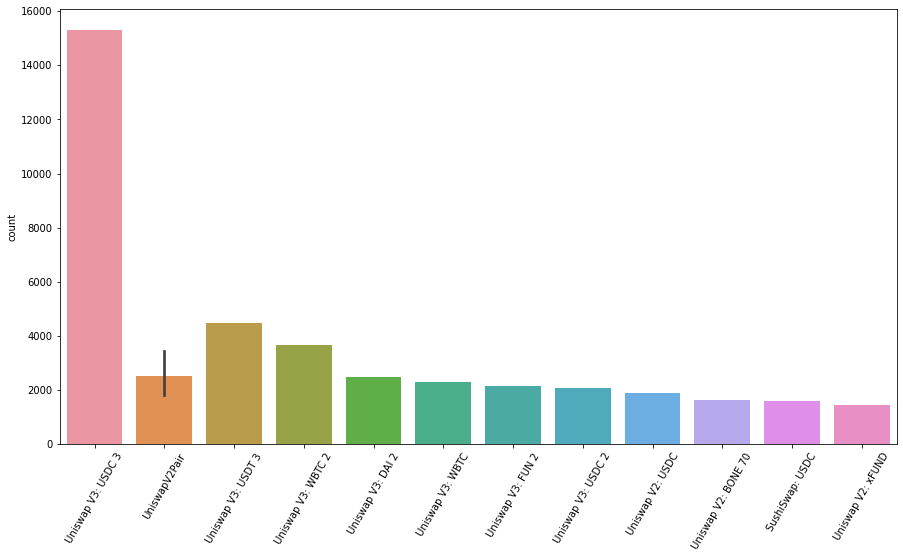

In [237]:
plt.figure(figsize=(15, 8))
sns.barplot(x=most_used_contracts.index.map(contract_name_tags), y=most_used_contracts['count'])
plt.xticks(rotation=60)
plt.show()

## Time-Series Analysis of Arbitrage Transactions

In [238]:
timed_arb_df = arb_df.set_index('timestamp', inplace=False)

daily_arb = timed_arb_df.resample('D')
daily_arb

In [239]:
daily_summary = daily_arb.agg({
    'transaction_hash': 'count',
    'block_number': ['min', 'max'],
    'account_address': pd.Series.nunique,
    'status': 'sum',
    'gas_price': ['min', 'max', 'mean', 'sum'],
    'gas_usage':  ['min', 'max', 'mean', 'sum'],
    'block_position': ['min', 'max', 'mean'],
    'profit_amount': ['min', 'max', 'mean', 'sum']
})

daily_summary

transaction_hash block_number           account_address status  \
                      count          min       max         nunique    sum   
timestamp                                                                   
2022-07-23              205     15200022  15200765              40    203   
2022-07-24             2377     15200775  15207186              83   2363   
2022-07-25             2539     15207190  15213597              82   2513   
2022-07-26             1849     15213599  15219962              83   1826   
2022-07-27             2532     15219970  15226396              93   2499   
2022-07-28             2951     15226411  15232876              92   2917   
2022-07-29             2789     15232891  15239277              92   2757   
2022-07-30             3064     15239293  15245680              82   3033   
2022-07-31             2822     15245692  15252147              99   2792   
2022-08-01             2284     15252149  15258559              87   2268   
2022-08-02             2680     15258565  15264990              97   2655   
2022-08-03             2102     15264993  15271305              86   2080   
2022-08-04             2265     15271325  15277737              83   2252   
2022-08-05             2361     15277745  15284166              86   2342   
2022-08-06             2317     15284221  15290607              89   2285   
2022-08-07             2061     15290612  15297091              80   2052   
2022-08-08             2304     15297111  15303433             100   2281   
2022-08-09             2059     15303446  15309830              89   2028   
2022-08-10             2021     15309843  15316214              84   1983   
2022-08-11             1813     15316215  15322522              89   1768   
2022-08-12             1925     15322524  15328863              92   1891   
2022-08-13             2984     15328864  15335254              90   2942   
2022-08-14             3038     15335262  15341609              95   3008   
2022-08-15             2529     15341622  15347838              97   2493   
2022-08-16             2147     15347840  15354233             100   2124   
2022-08-17             2416     15354253  15360556              91   2376   
2022-08-18             1712     15360565  15366820              89   1700   
2022-08-19             2719     15366840  15373147             104   2674   
2022-08-20             2513     15373148  15379447              95   2487   
2022-08-21             3112     15379448  15385831             102   3053   
2022-08-22             2790     15385836  15392121             100   2687   
2022-08-23             2489     15392125  15398490             104   2371   
2022-08-24             2105     15398497  15404750              92   2073   
2022-08-25             2214     15404753  15410906              83   2090   
2022-08-26             2710     15410915  15417183             104   2640   
2022-08-27             2955     15417190  15423431             101   2925   
2022-08-28             2292     15423434  15429676              92   2283   
2022-08-29             2604     15429681  15435930              97   2577   
2022-08-30             2973     15435947  15442193             102   2953   
2022-08-31             1828     15442204  15448450              94   1811   
2022-09-01             1875     15448451  15454678              88   1868   
2022-09-02             2261     15454693  15461001              97   2223   
2022-09-03             2138     15461006  15467208              96   2130   
2022-09-04             1950     15467210  15473461             101   1937   
2022-09-05             2015     15473471  15479645             119   2002   
2022-09-06             2807     15479648  15485928             102   2784   
2022-09-07             2527     15485934  15492129             103   2484   
2022-09-08             2707     15492180  15498413             107   2683   
2022-09-09              430     15498416  15499997              59    424   

      

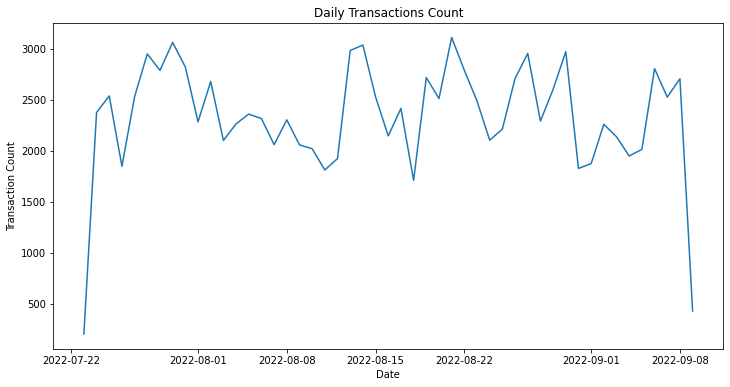

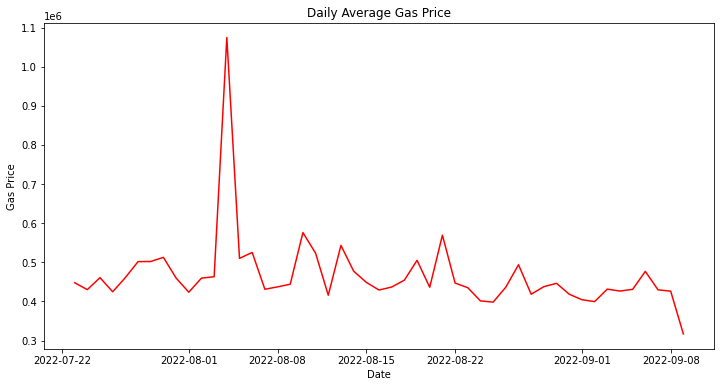

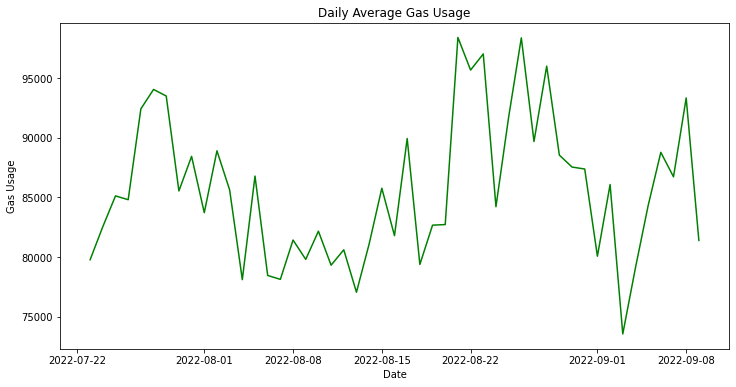

In [240]:
plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['transaction_hash', 'count'])
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transactions Count')

plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['gas_price', 'mean'], color='red')
plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.title('Daily Average Gas Price')

plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['gas_usage', 'mean'], color='green')
plt.xlabel('Date')
plt.ylabel('Gas Usage')
plt.title('Daily Average Gas Usage')

plt.show()

## Time-Series Analysis of Accounts

In [241]:
def plot_address_activity(_address, color, _column):
    address_mask = timed_arb_df[_column].str.split(',').apply(lambda x: _address in x)
    address_df = timed_arb_df[address_mask]
    daily_tx_count = address_df.groupby(pd.Grouper(freq='D')).agg({'transaction_hash': 'count'})
    plt.plot(daily_tx_count.index, daily_tx_count['transaction_hash'], color=color)

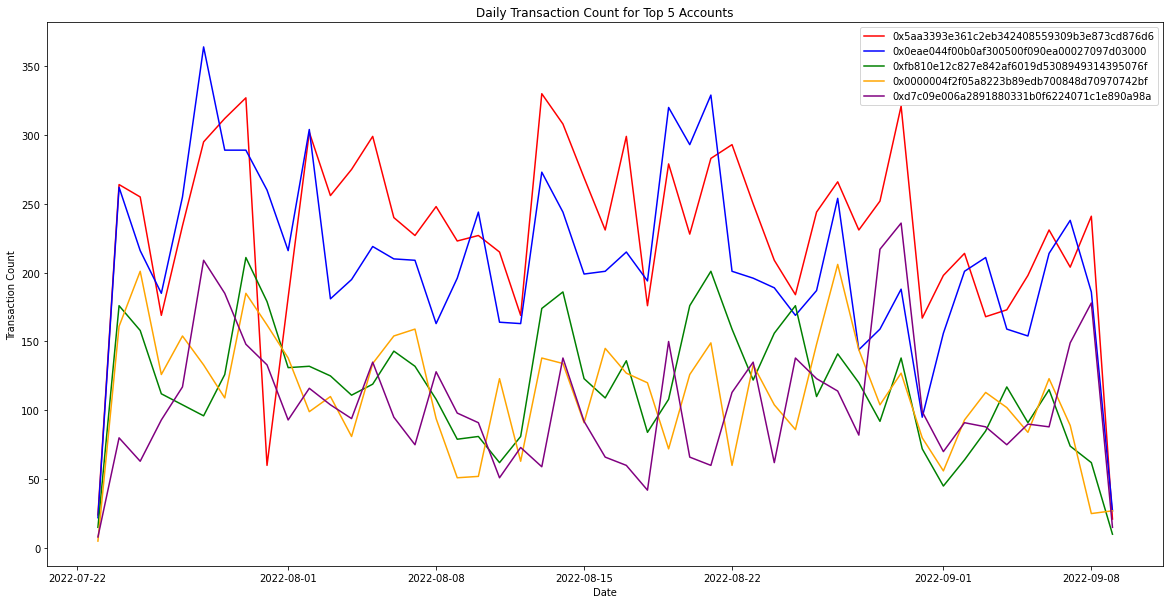

In [242]:
colors = ['red', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(20,10))
for i, account_address in enumerate(top_addresses.head(5).index):
    plot_address_activity(_address=account_address, color=colors[i], _column='account_address')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Top 5 Accounts')
plt.legend(top_addresses.head(5).index, loc='best')
plt.show()

## Time-Series Analysis of Contracts

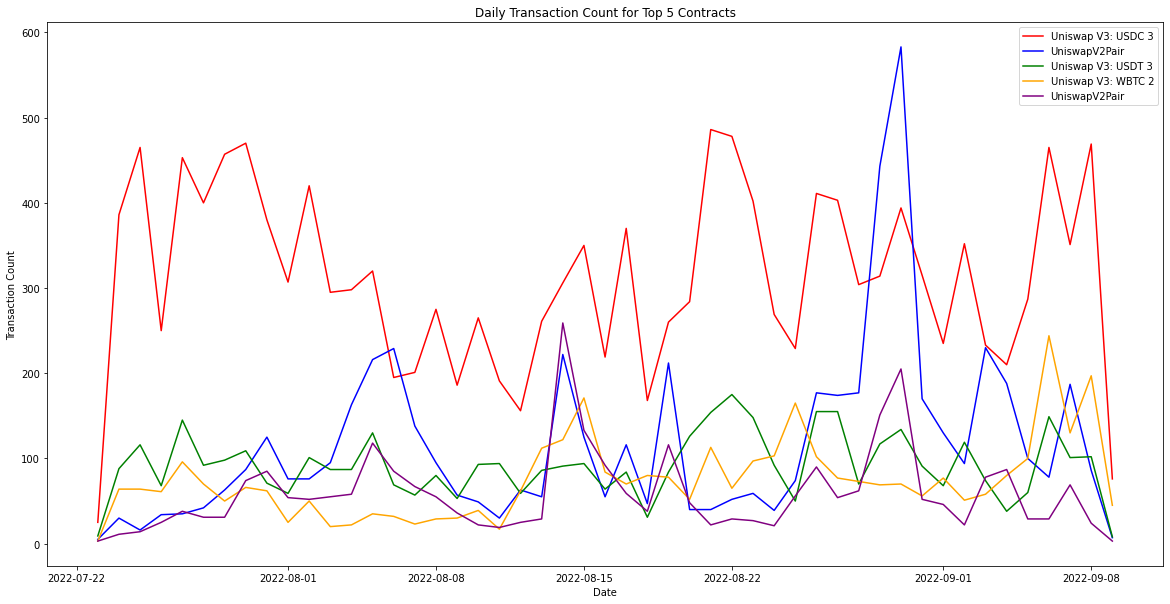

In [243]:
plt.figure(figsize=(20,10))
for i, contract_address in enumerate(most_used_contracts.head(5).index):
    plot_address_activity(_address=contract_address, color=colors[i], _column='contracts_address')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Top 5 Contracts')
plt.legend(most_used_contracts.index.map(contract_name_tags), loc='best')
plt.show()

## Time-Series Analysis of Tokens

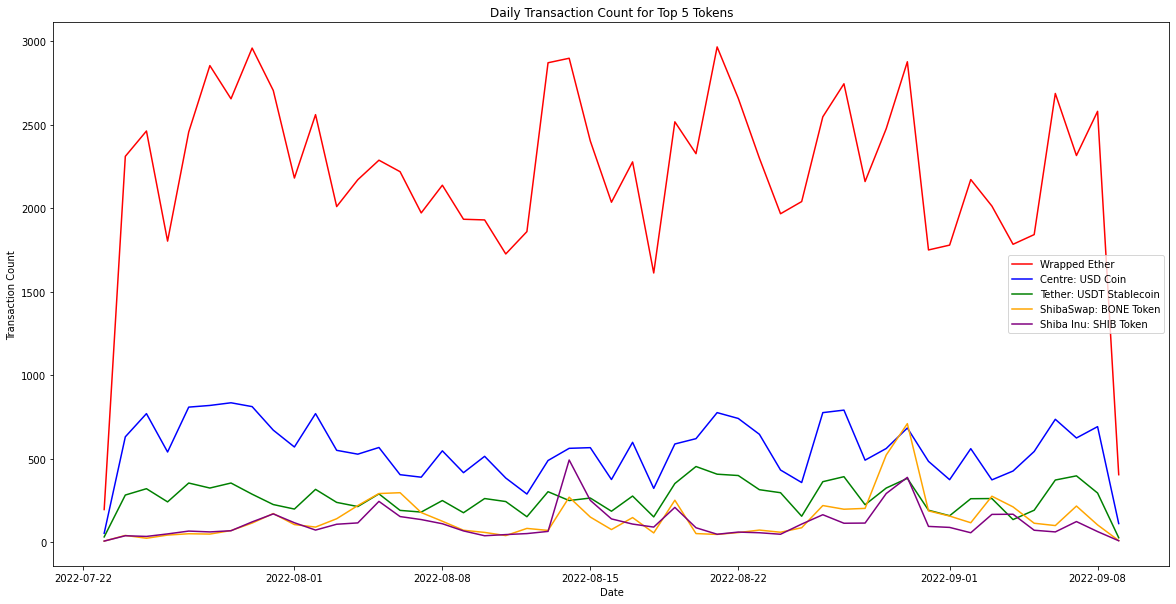

In [244]:
plt.figure(figsize=(20,10))
for i, token_address in enumerate(most_used_tokens.head(5).index):
    plot_address_activity(_address=token_address, color=colors[i], _column='input_tokens_address')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Top 5 Tokens')
plt.legend(most_used_tokens.index.map(token_name_tags), loc='best')
plt.show()

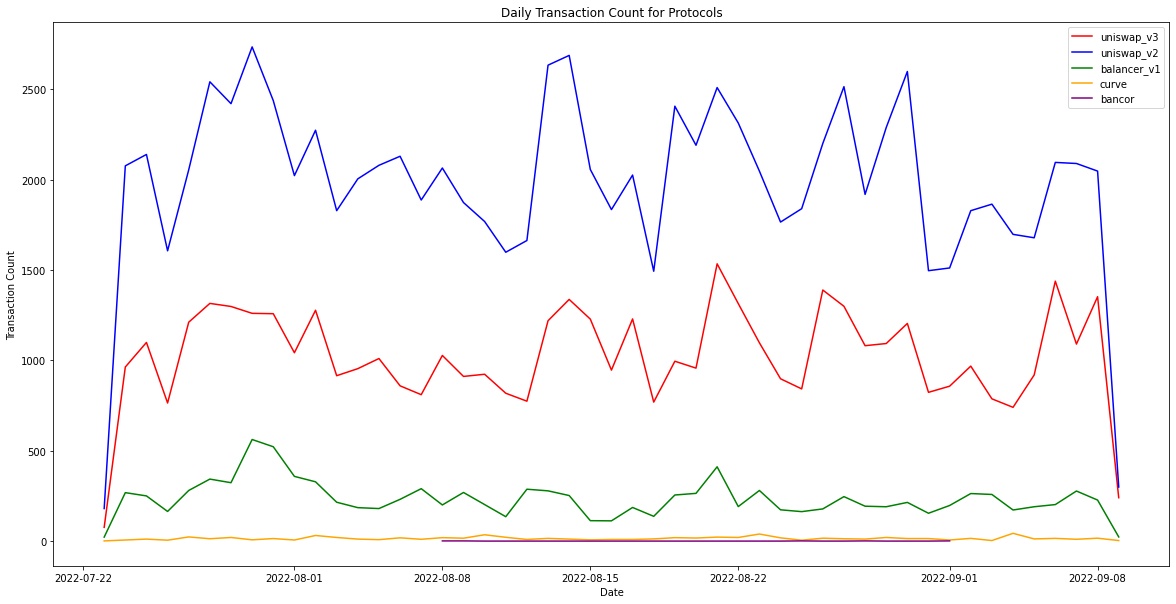

In [256]:
protocols = arb_df['protocols'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('protocol')['protocol'].unique()

plt.figure(figsize=(20,10))
for i, protocol in enumerate(protocols):
    plot_address_activity(_address=protocol, color=colors[i], _column='protocols')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Protocols')
plt.legend(protocols, loc='best')
plt.show()

## Block position

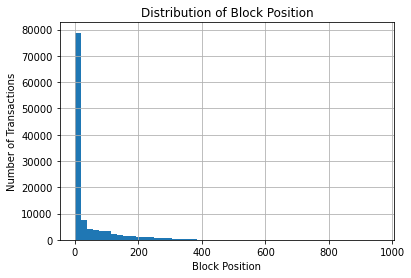

In [246]:
arb_df['block_position'].hist(bins=50)
plt.title('Distribution of Block Position')
plt.xlabel('Block Position')
plt.ylabel('Number of Transactions')
plt.show()

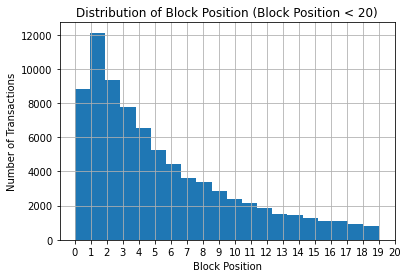

In [247]:
# Filter the data to include only block positions less than 20
filtered_df = arb_df[arb_df['block_position'] < 20]

# Plot the distribution of block_position less than 20 as a histogram
filtered_df['block_position'].hist(bins=20)
plt.title('Distribution of Block Position (Block Position < 20)')
plt.xlabel('Block Position')
plt.ylabel('Number of Transactions')
plt.xticks(np.arange(21))
plt.show()

## Protocols

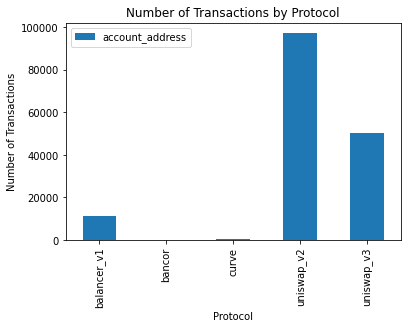

In [248]:
# Parse the protocols column and group by protocol
protocols_df = arb_df['protocols'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('protocol')
protocols_df = protocols_df.join(arb_df['account_address'])
protocols_df = protocols_df.groupby(['protocol']).count().reset_index()

# Plot the results as a bar chart
protocols_df.plot(x='protocol', y='account_address', kind='bar')
plt.title('Number of Transactions by Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Transactions')
plt.show()

In [249]:
# TODO: normalise